## Linear Auto Encoders Fashion mnist

### Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms

In [18]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define a transformation and remove the .normalize transform

transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load dataset
dataset = datasets.FashionMNIST(root='/root/data', train=True, download=True, transform=transform)

# Create DataLoader with multiple workers
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)

In [19]:
import torch
def mean_std(dataloader):
    #finding mean and std for input images

    summ_means, squared_sum_mean, num_batches= 0, 0, 0
    num_batches = len(dataloader)

    for data,label in dataloader:
        # Mean over batch, height and width, but not over the channels
        summ_means += torch.mean(data) #sum of means for all batches
        squared_sum_mean += torch.mean(data**2) #sum of mean of squares for all batches

    mean_gray = summ_means / len(dataloader) #num_batches = len(dataloader)

    # std = sqrt(E[X^2] - (E[X])^2)
    std_gray = (squared_sum_mean / num_batches - mean_gray ** 2) ** 0.5
    print("Mean is ",mean_gray.item()," STD is ",std_gray.item())
    return mean_gray,std_gray

mean_std(dataloader)

Mean is  0.28604698181152344  STD is  0.35302111506462097


(tensor(0.2860), tensor(0.3530))

In [20]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define a transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.286,), (0.353,))
])

# Load dataset
train_dataset = datasets.FashionMNIST(root='/root/data', train=True, download=True, transform=transform)
# split the training dataset into training and validation datasets
train_dataset,valid_dataset = torch.utils.data.random_split(train_dataset,[50000,10000])
test_dataset = datasets.FashionMNIST(root='/root/data', train=False, download=True, transform=transform)

# Create DataLoader with multiple workers
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=True)


In [21]:

print(f"Training dataset size: {len(train_dataloader.dataset)}")
print(f"Validation dataset size: {len(valid_loader.dataset)}")
print(f"Test dataset size: {len(test_loader.dataset)}")

Training dataset size: 50000
Validation dataset size: 10000
Test dataset size: 10000


### Let's recap From last session (NN)

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init


# Define your neural network architecture
class NeuralNet(nn.Module): #inheretence concept
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU() #whether you will use this many times or not , Define it once
        self.fc1 = nn.Linear(784, 256) # Common approach 2^n

        init.uniform_(self.fc1.weight,a=0.1, b=1.1)
        init.zeros_(self.fc1.bias)

        self.fc2 = nn.Linear(256, 10) #why 10 ?
        init.xavier_uniform_(self.fc2.weight, gain=1.1)



    def forward(self, x):
        x = self.flatten(x) # 28x28 --> 784
        x = self.fc1(x)   # 784 --> 256
        x = self.relu(x)
        x = self.fc2(x) # 256-->10 #Is dependent on the loss you will use
        #x = torch.softmax(x, dim=1)
        return x


# Instantiate the neural network
model_NN = NeuralNet()

### Linear autoencoder

Autoencoders are unsupervised learning type of ML algorithms used for:

- Images reconstruction
- Impainting
- Denoising

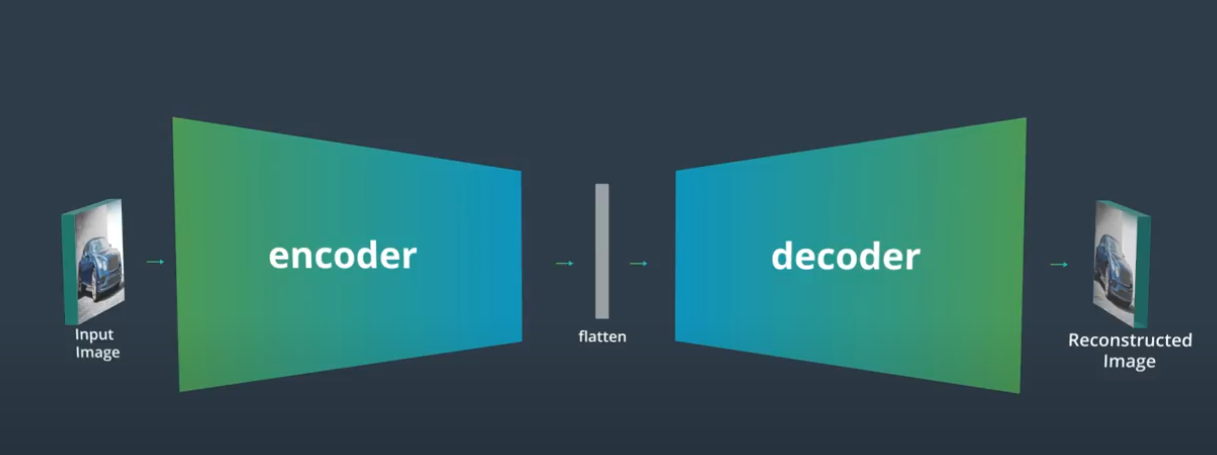


In [8]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class Autoencoder(nn.Module):
    
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        ## encoder ##
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, encoding_dim),
            nn.ReLU(),
            nn.BatchNorm1d(encoding_dim),

        )
        
        ## decoder ##
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 28*28),
            nn.Sigmoid()
        )
        
        self.auto_encoder = nn.Sequential(
            nn.Flatten(),
            self.encoder,
            self.decoder
        )

    def forward(self, x):
        # define feedforward behavior 
        # and scale the *output* layer with a sigmoid activation function
        
        encoded = self.auto_encoder(x)
        
        # Reshape the output as an image
        # remember that the shape should be (batch_size, channel_count, height, width)
        return encoded.reshape((x.shape[0], 1, 28, 28))

In [8]:
import torch

# ✍️Check if CUDA is available
device = "cuda" if torch.cuda.is_available() else "cpu"
# ✍️Move the model to the GPU if CUDA is available

In [10]:
# initialize the Auto encoder
encoding_dim = 32
model = Autoencoder(encoding_dim)
model.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=256, out_features=32, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=256, out_features=784, bias=True)
    (4): Sigmoid()
  )
  (auto_encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Sequential(
      (0): Linear(in_features=784, out_features=256, bias=True)
      (1): ReLU()
      (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Linear(in_features=256, out_features=32, bias=True)
      (4): ReLU()

### Loss function &  Optimizer

In [11]:
# specify loss function
criterion = nn.MSELoss()

In [20]:
# specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-2)

### Let's recap From last sessions (Training loop)


Epoch 1: Training Loss = 0.9869172425983507
Epoch 1: Validation Loss = 0.9788143194405137
Epoch 2: Training Loss = 0.9763235391863166
Epoch 2: Validation Loss = 0.9760749947493244
Epoch 3: Training Loss = 0.9663643047327886
Epoch 3: Validation Loss = 0.9694354610078654
Epoch 4: Training Loss = 0.9567536259703624
Epoch 4: Validation Loss = 0.9496539166778516
Epoch 5: Training Loss = 0.9470844806155281
Epoch 5: Validation Loss = 0.9396031544466686
Epoch 6: Training Loss = 0.9375740161637212
Epoch 6: Validation Loss = 0.9299495884567309
Epoch 7: Training Loss = 0.9281333895290599
Epoch 7: Validation Loss = 0.9218161375659286
Epoch 8: Training Loss = 0.9183190502321629
Epoch 8: Validation Loss = 0.9146608547040611
Epoch 9: Training Loss = 0.90834069038596
Epoch 9: Validation Loss = 0.900522311781622
Epoch 10: Training Loss = 0.8979721275894234
Epoch 10: Validation Loss = 0.8921979810022245


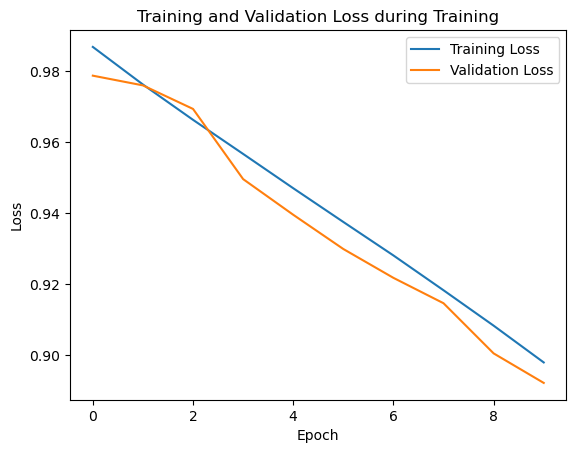

In [21]:
import matplotlib.pyplot as plt


# Train the neural network
Epochs = 10
training_losses = []
validation_losses = []
best_val_loss = float('inf') #A very big number approaching infinity
optimizer = optim.SGD(model.parameters(), lr=0.01)


for epoch in range(Epochs): # 10  Epochs
    model.train()
    running_loss = 0.0
    valid_loss = 0.0
    for inputs, labels in train_dataloader: #looping the batches

        inputs = inputs.to(device)
        # Zero the gradients
        optimizer.zero_grad()  #ensures that the gradients are cleared or reset to zero before the next forward-backward pass.
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.flatten(), inputs.flatten())

        # Backward pass and optimization
        loss.backward() #calculate the gradients
        #update our weights of each Batch
        optimizer.step()

        running_loss += loss.item() #accumulating losses over batches

    total_loss = running_loss/len(train_dataloader)
    training_losses.append(total_loss)
    print(f"Epoch {epoch+1}: Training Loss = {total_loss}") # Batch loss=Total losses/number of batches

    model.eval()
    for inputs, labels in valid_loader: #looping the batches
        inputs = inputs.to(device)
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.flatten(), inputs.flatten())

        valid_loss += loss.item() #accumulating losses over batches

    total_loss = valid_loss/len(valid_loader)
    validation_losses.append(total_loss)
    
    print(f"Epoch {epoch+1}: Validation Loss = {total_loss}") # Batch loss=Total losses/number of batches
    if total_loss < best_val_loss:
        best_val_loss = total_loss
        best_state_dict = model.state_dict()


torch.save(best_state_dict, 'best_model.pth')

#Plot traing and validation losses saved in the training loops
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss during Training')
plt.legend()
plt.show()  

### Testing 

In [22]:
model.to(device)
# Step 2: Load the saved weights
model.load_state_dict(torch.load(f"best_model.pth"))

# Step 3: Move model to device and set to eval mode
model.eval()

# Step 4: Run inference on test data
correct = 0
total = 0
test_loss = 0 
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs.flatten(), inputs.flatten())
        test_loss += loss.item() #accumulating losses over batches
        
    total_loss = test_loss/len(test_loader)

print(f"Test Loss = {total_loss}")


Test Loss = 0.8893704831979836


### See how the images are reconstructed

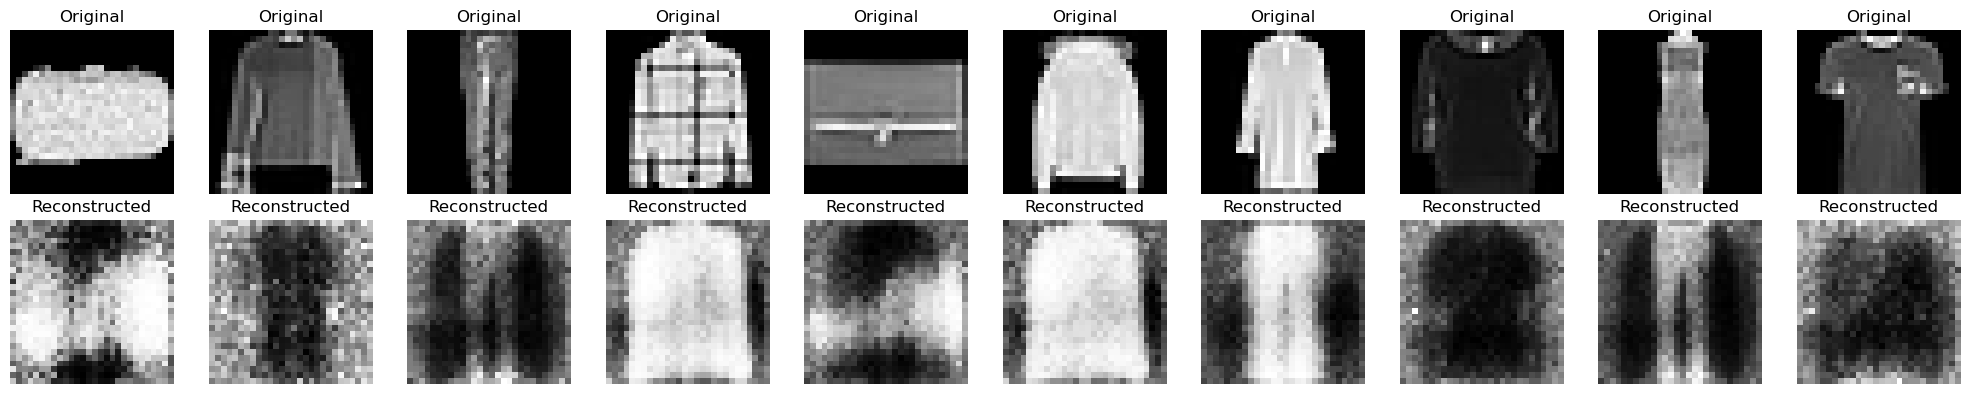

In [23]:
import numpy as np

# Load best model weights
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Get a batch from the validation set
dataiter = iter(valid_loader)
images, _ = next(dataiter)  # we don't need labels
images = images.to(device)

# Get reconstructed images
with torch.no_grad():
    reconstructed = model(images)

# Move to CPU and convert to numpy
images = images.cpu().numpy()
reconstructed = reconstructed.cpu().numpy()

# Plot original vs reconstructed
n = 10  # number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title("Original")
    plt.axis("off")

    # Reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed[i].squeeze(), cmap='gray')
    plt.title("Reconstructed")
    plt.axis("off")

plt.tight_layout()
plt.show()


### Conolutional Autoencoders: Transposed convolution:
Transposed convolution layers (deconvolution): Layers used during upsampling, it applies learnable kernel to the doensampled input to generate an upsampled output.

The most commonly used approach is a 2x2 kernel with a stride of 2 to double wifth and height of the input.

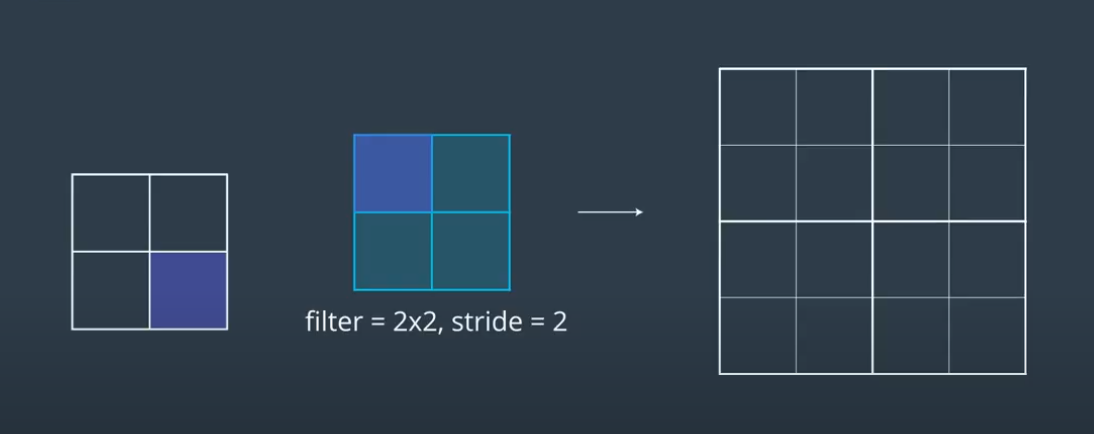

You can generate a Transposed Convolution Layer in PyTorch with:

`unpool = nn.ConvTranspose2d(input_ch, output_ch, kernel_size, stride=2)`

Documntation is here for [ConvTranspose2d](https://docs.pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html).

For example, we can generate a Transposed Convolution Layer that doubles the size of an input grayscale image and generates 16 feature maps as follows:

`unpool = nn.ConvTranspose2d(1, 16, 2, stride=2)
`

### Alternative to transposed convolution:
The Transposed Convolutions tend to produce checkerboard artifacts (unwanted grid-like or patchy patterns that appear in images generated). 

These patterns look like:

- Repeating squares or blocks (like a checkerboard)
- Uneven textures or pixel intensity jumps
- Regular noise in upsampled images that shouldn't be there
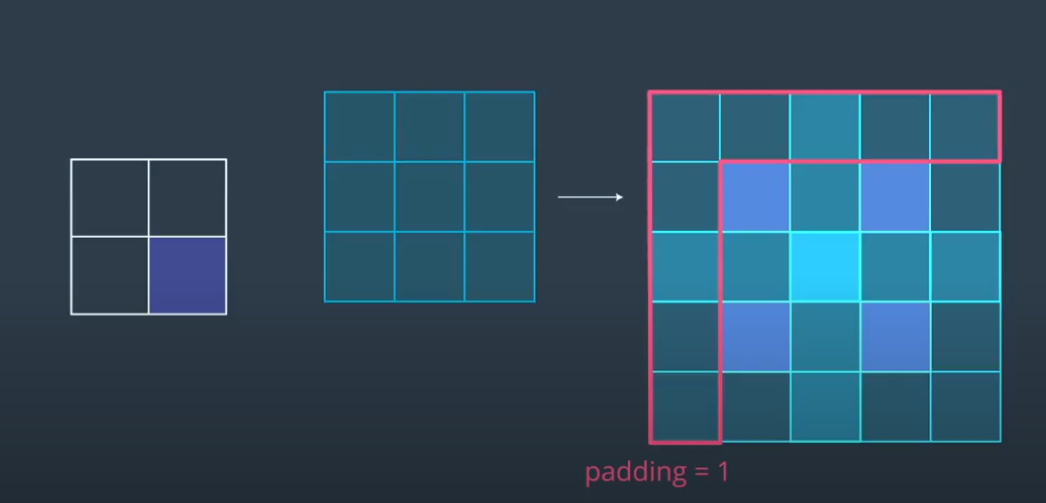

Therefore, nowadays many practitioners replace them with a nearest-neighbor upsampling operation followed by a convolution operation. 

The convolution makes the image produced by the nearest-neighbors smoother. For example, we can replace this Transposed Convolution:

`unpool = nn.ConvTranspose2d(1, 16, 2, stride=2)`

with

```
unpool = nn.Sequential(
    nn.Upsample(scale_factor = 2, mode='nearest'),
    nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
)
```
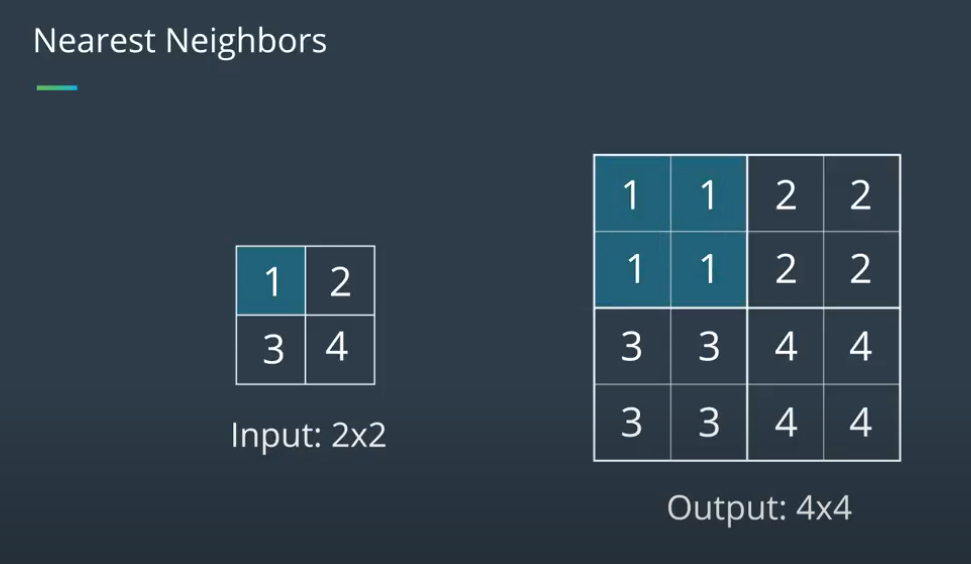

In [13]:

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        ## encoder ##
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 3, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        ## decoder ##
        self.decoder = nn.Sequential(
            # Undo the Max Pooling
            nn.ConvTranspose2d(3, 1, 2, stride=2),
            nn.Sigmoid()
        )

        self.auto_encoder = nn.Sequential(
            self.encoder,
            self.decoder
        )

    def forward(self, x):
        # define feedforward behavior 
        # and scale the *output* layer with a sigmoid activation function

        return self.auto_encoder(x)
    
model = Autoencoder()
model.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(3, 1, kernel_size=(2, 2), stride=(2, 2))
    (1): Sigmoid()
  )
  (auto_encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): ConvTranspose2d(3, 1, kernel_size=(2, 2), stride=(2, 2))
      (1): Sigmoid()
    )
  )
)

Epoch 1: Training Loss = 1.0501406938218705
Epoch 1: Validation Loss = 0.9348069850806218
Epoch 2: Training Loss = 0.7103869734365312
Epoch 2: Validation Loss = 0.5734493895700783
Epoch 3: Training Loss = 0.5491558053838018
Epoch 3: Validation Loss = 0.5398834226237741
Epoch 4: Training Loss = 0.5322071069570453
Epoch 4: Validation Loss = 0.5308033136805151
Epoch 5: Training Loss = 0.5261541688457474
Epoch 5: Validation Loss = 0.5266954817210033
Epoch 6: Training Loss = 0.5227561575143843
Epoch 6: Validation Loss = 0.5239962238794679
Epoch 7: Training Loss = 0.5204342963064418
Epoch 7: Validation Loss = 0.5216103704871645
Epoch 8: Training Loss = 0.5184743863618587
Epoch 8: Validation Loss = 0.5202680609788105
Epoch 9: Training Loss = 0.5167609519513366
Epoch 9: Validation Loss = 0.5183644254875791
Epoch 10: Training Loss = 0.515153522267366
Epoch 10: Validation Loss = 0.5167373999668534


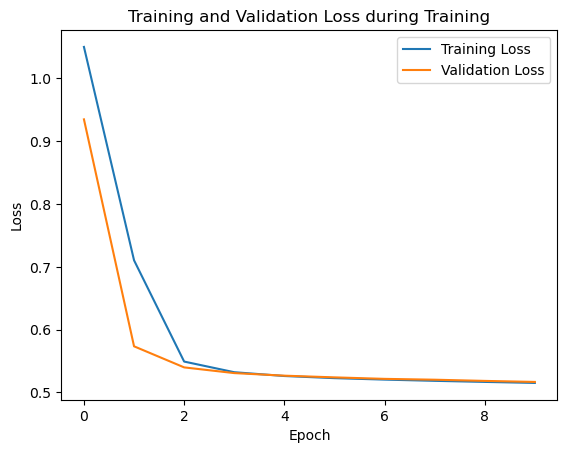

In [ ]:
import matplotlib.pyplot as plt


# Train the neural network
Epochs = 10
training_losses = []
validation_losses = []
best_val_loss = float('inf') #A very big number approaching infinity
optimizer = optim.SGD(model.parameters(), lr=0.01)


for epoch in range(Epochs): # 10  Epochs
    model.train()
    running_loss = 0.0
    valid_loss = 0.0
    for inputs, labels in train_dataloader: #looping the batches

        inputs = inputs.to(device)
        # Zero the gradients
        optimizer.zero_grad()  #ensures that the gradients are cleared or reset to zero before the next forward-backward pass.
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.flatten(), inputs.flatten())

        # Backward pass and optimization
        loss.backward() #calculate the gradients
        #update our weights of each Batch
        optimizer.step()

        running_loss += loss.item() #accumulating losses over batches

    total_loss = running_loss/len(train_dataloader)
    training_losses.append(total_loss)
    print(f"Epoch {epoch+1}: Training Loss = {total_loss}") # Batch loss=Total losses/number of batches

    model.eval()
    for inputs, labels in valid_loader: #looping the batches
        inputs = inputs.to(device)
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.flatten(), inputs.flatten())

        valid_loss += loss.item() #accumulating losses over batches

    total_loss = valid_loss/len(valid_loader)
    validation_losses.append(total_loss)
    
    print(f"Epoch {epoch+1}: Validation Loss = {total_loss}") # Batch loss=Total losses/number of batches
    if total_loss < best_val_loss:
        best_val_loss = total_loss
        best_state_dict = model.state_dict()


torch.save(best_state_dict, 'best_model.pth')

#Plot traing and validation losses saved in the training loops
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss during Training')
plt.legend()
plt.show()  

### Show reconstructed images

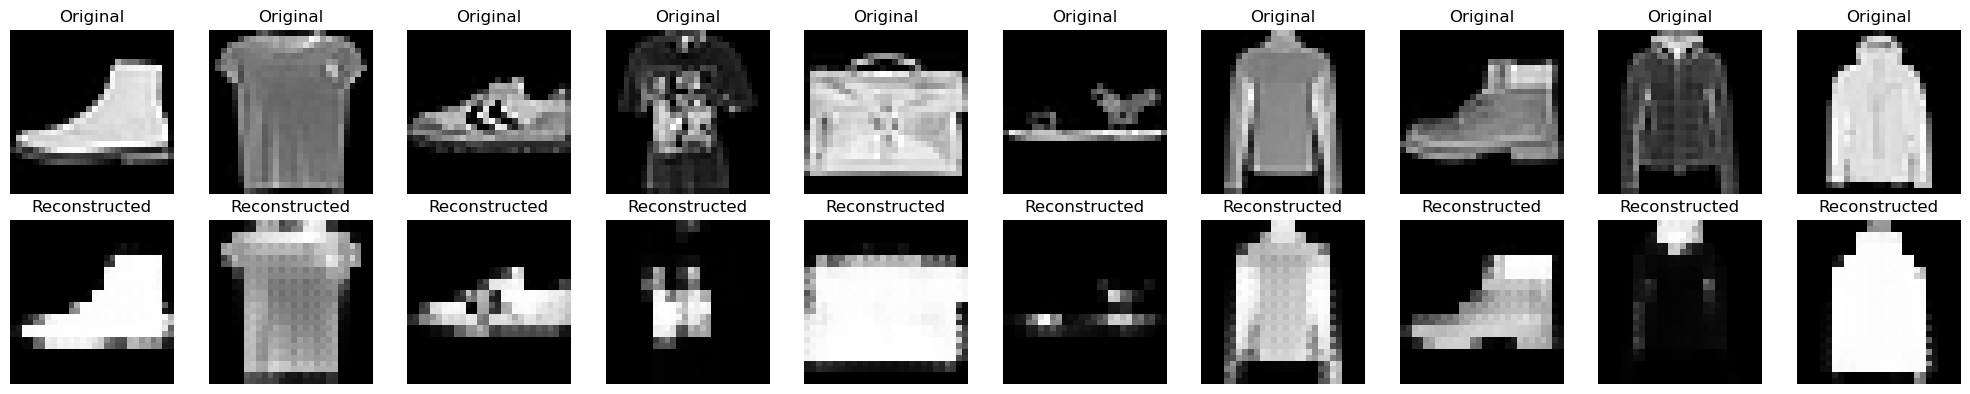

In [15]:
import numpy as np

# Load best model weights
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Get a batch from the validation set
dataiter = iter(valid_loader)
images, _ = next(dataiter)  # we don't need labels
images = images.to(device)

# Get reconstructed images
with torch.no_grad():
    reconstructed = model(images)

# Move to CPU and convert to numpy
images = images.cpu().numpy()
reconstructed = reconstructed.cpu().numpy()

# Plot original vs reconstructed
n = 10  # number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title("Original")
    plt.axis("off")

    # Reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed[i].squeeze(), cmap='gray')
    plt.title("Reconstructed")
    plt.axis("off")

plt.tight_layout()
plt.show()


### Task#1 
Create a more complex autoencoder. eplace question marks

In [9]:

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        ## encoder ##
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            # ToDO: add a batch normalization layer
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            # ToDO: add a second convolution layer that generates 32 feature maps
            #Keep stride = 1, padding = 1 for similar output size
            nn.Conv2d(32, 32, 3, padding=1),
            # Apply ReLU activation function
            nn.ReLU(),
            # ToDO: add a batch normalization layer
            nn.BatchNorm2d(32),
            # ToDO: add a max pooling layer of size 2x2
            nn.MaxPool2d(2, 2)
            
        )

        ## decoder ##
        self.decoder = nn.Sequential(
            # Undo the Max Pooling using upsampling + convolution
            nn.Upsample(scale_factor = 2, mode='nearest'),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            # Apply ReLU activation function
            nn.ReLU(),
            # ToDO: add a batch normalization layer
            nn.BatchNorm2d(32),
            # Undo the Max Pooling using upsampling + convolution
            nn.Upsample(scale_factor = 2, mode='nearest'),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            # Apply ReLU activation function
            nn.ReLU(),
            # ToDO: add a batch normalization layer
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 1, 3, padding=1),
            nn.Sigmoid()
            
        )

        self.auto_encoder = nn.Sequential(
            self.encoder,
            self.decoder
        )

    def forward(self, x):
        # define feedforward behavior 
        # and scale the *output* layer with a sigmoid activation function

        return self.auto_encoder(x)
    
model = Autoencoder()
model.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): Upsample(scale_factor=2.0, mode='nearest')
    (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Upsample(scale_factor=2.0, mode='nearest')
    (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): BatchNorm2d(32, eps=1e

Epoch 1: Training Loss = 0.5319328464358054
Epoch 1: Validation Loss = 0.5016881749508487
Epoch 2: Training Loss = 0.4980139423666708
Epoch 2: Validation Loss = 0.4904217198016537
Epoch 3: Training Loss = 0.4895667748530502
Epoch 3: Validation Loss = 0.48415436885159485
Epoch 4: Training Loss = 0.4843481847316103
Epoch 4: Validation Loss = 0.47954235202187945
Epoch 5: Training Loss = 0.480458480889535
Epoch 5: Validation Loss = 0.47655910158612924
Epoch 6: Training Loss = 0.4776110454745915
Epoch 6: Validation Loss = 0.47390283255060767
Epoch 7: Training Loss = 0.4751249887144474
Epoch 7: Validation Loss = 0.4715289667153814
Epoch 8: Training Loss = 0.4729848400406215
Epoch 8: Validation Loss = 0.4697417808566124
Epoch 9: Training Loss = 0.47111876034523215
Epoch 9: Validation Loss = 0.46845740117844503
Epoch 10: Training Loss = 0.4697824736385394
Epoch 10: Validation Loss = 0.46696300624282494


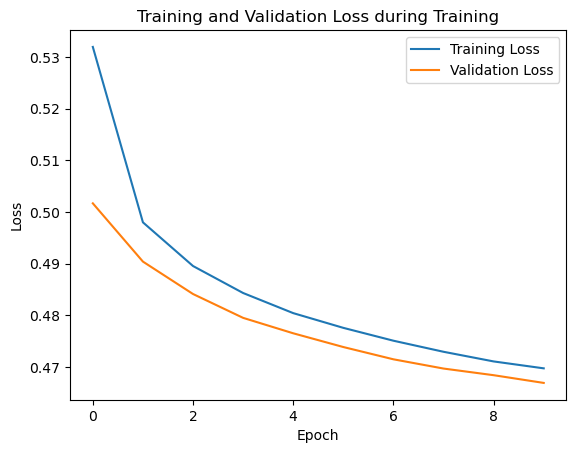

In [12]:
import matplotlib.pyplot as plt


# Train the neural network
Epochs = 10
training_losses = []
validation_losses = []
best_val_loss = float('inf') #A very big number approaching infinity
optimizer = optim.SGD(model.parameters(), lr=0.01)


for epoch in range(Epochs): # 10  Epochs
    model.train()
    running_loss = 0.0
    valid_loss = 0.0
    for inputs, labels in train_dataloader: #looping the batches

        inputs = inputs.to(device)
        # Zero the gradients
        optimizer.zero_grad()  #ensures that the gradients are cleared or reset to zero before the next forward-backward pass.
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.flatten(), inputs.flatten())

        # Backward pass and optimization
        loss.backward() #calculate the gradients
        #update our weights of each Batch
        optimizer.step()

        running_loss += loss.item() #accumulating losses over batches

    total_loss = running_loss/len(train_dataloader)
    training_losses.append(total_loss)
    print(f"Epoch {epoch+1}: Training Loss = {total_loss}") # Batch loss=Total losses/number of batches

    model.eval()
    for inputs, labels in valid_loader: #looping the batches
        inputs = inputs.to(device)
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.flatten(), inputs.flatten())

        valid_loss += loss.item() #accumulating losses over batches

    total_loss = valid_loss/len(valid_loader)
    validation_losses.append(total_loss)
    
    print(f"Epoch {epoch+1}: Validation Loss = {total_loss}") # Batch loss=Total losses/number of batches
    if total_loss < best_val_loss:
        best_val_loss = total_loss
        best_state_dict = model.state_dict()


torch.save(best_state_dict, 'best_model.pth')

#Plot traing and validation losses saved in the training loops
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss during Training')
plt.legend()
plt.show()  

### Show reconstructed images

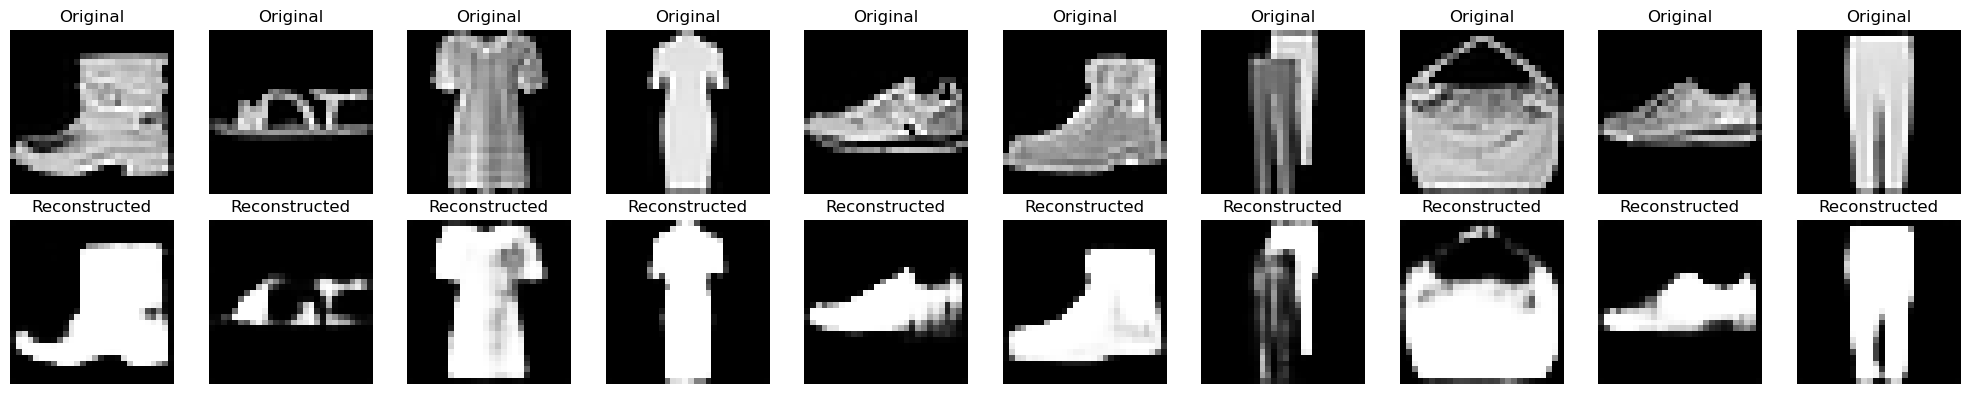

In [13]:
import numpy as np

# Load best model weights
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Get a batch from the validation set
dataiter = iter(valid_loader)
images, _ = next(dataiter)  # we don't need labels
images = images.to(device)

# Get reconstructed images
with torch.no_grad():
    reconstructed = model(images)

# Move to CPU and convert to numpy
images = images.cpu().numpy()
reconstructed = reconstructed.cpu().numpy()

# Plot original vs reconstructed
n = 10  # number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title("Original")
    plt.axis("off")

    # Reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed[i].squeeze(), cmap='gray')
    plt.title("Reconstructed")
    plt.axis("off")

plt.tight_layout()
plt.show()


### Fashion MNIST denoising

Sticking with the Fashion MNIST dataset, let's add noise to our data and see if we can define and train an autoencoder to _de_-noise the images.


autoencoders like the ones you've built so far aren't too useful in practice. However, they can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1.

>**We'll use noisy images as input and the original, clean images as targets.** 

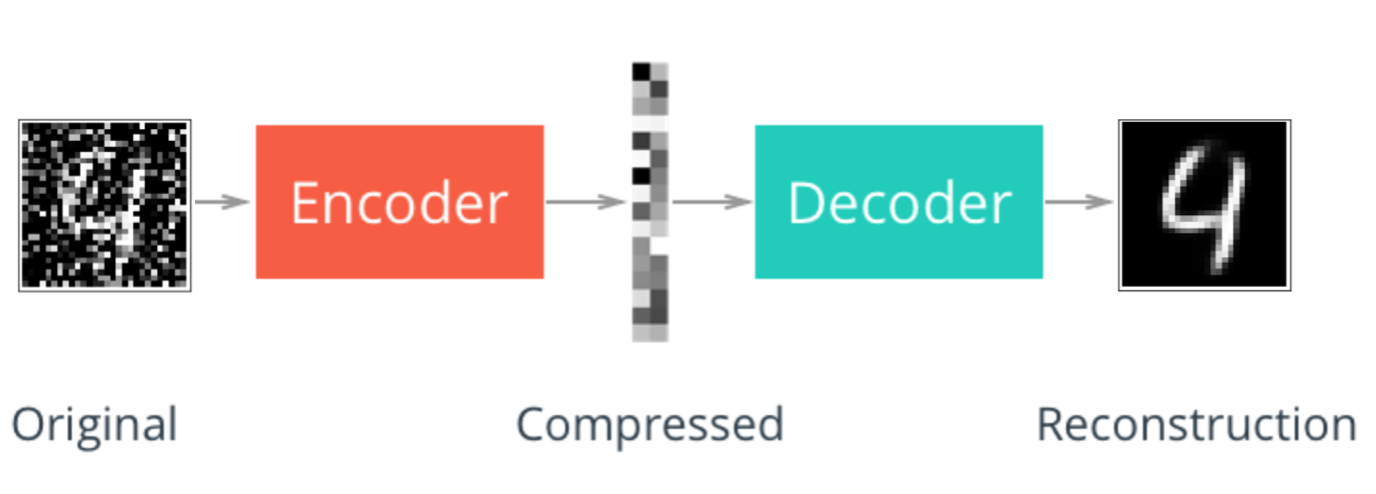

In [35]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvDenoiser(nn.Module):
    def __init__(self):
        super(ConvDenoiser, self).__init__()
        ## encoder layers ##
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 16, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(16, 8, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(2, 2)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 8, 3, stride=2), 
            nn.ReLU(),
            nn.BatchNorm2d(8),
            
            nn.ConvTranspose2d(8, 16, 2, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            
            nn.ConvTranspose2d(16, 32, 2, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(32, 1, 3, padding=1),
            nn.Sigmoid()
        )
        
        self.model = nn.Sequential(
            self.encoder,
            self.decoder
        )

    def forward(self, x):
                
        return self.model(x)


# initialize the NN
model = ConvDenoiser()
model.to(device)

ConvDenoiser(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=Tru

Epoch 1: Training Loss = 0.5279664391142023
Epoch 1: Validation Loss = 0.5234568986543424
Epoch 2: Training Loss = 0.5264288462946177
Epoch 2: Validation Loss = 0.5219549084924588
Epoch 3: Training Loss = 0.5253316604953897
Epoch 3: Validation Loss = 0.5203319034378999
Epoch 4: Training Loss = 0.5243011756854898
Epoch 4: Validation Loss = 0.5195458609207421
Epoch 5: Training Loss = 0.5230356926274726
Epoch 5: Validation Loss = 0.5185242794501553
Epoch 6: Training Loss = 0.5221581181220691
Epoch 6: Validation Loss = 0.5178722556988904
Epoch 7: Training Loss = 0.5212368460567406
Epoch 7: Validation Loss = 0.5168400366974485
Epoch 8: Training Loss = 0.5204688664287558
Epoch 8: Validation Loss = 0.5160683547235598
Epoch 9: Training Loss = 0.5195580970143419
Epoch 9: Validation Loss = 0.5151313300345354
Epoch 10: Training Loss = 0.5187659083729814
Epoch 10: Validation Loss = 0.5145975717693377
Epoch 11: Training Loss = 0.5180293471764421
Epoch 11: Validation Loss = 0.5137097233799612
Epoch 

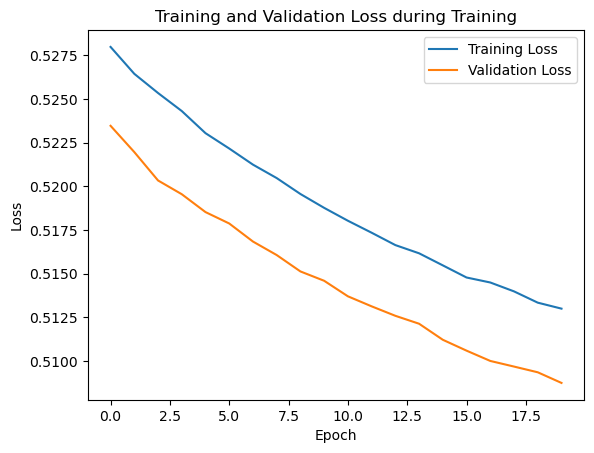

In [38]:
import matplotlib.pyplot as plt


# Train the neural network
Epochs = 20
training_losses = []
validation_losses = []
best_val_loss = float('inf') #A very big number approaching infinity
noise_factor = 0.5

optimizer = optim.SGD(model.parameters(), lr=0.01)


for epoch in range(Epochs): # 10  Epochs
    model.train()
    running_loss = 0.0
    valid_loss = 0.0
    for inputs, labels in train_dataloader: #looping the batches
        
        inputs = inputs.to(device)
        ## add random noise to the input images
        noisy_imgs = inputs + noise_factor * torch.rand_like(inputs)
        # Clip the images to be between 0 and 1
        noisy_imgs = torch.clamp(noisy_imgs, 0., 1.)
        
        # Zero the gradients
        optimizer.zero_grad()  #ensures that the gradients are cleared or reset to zero before the next forward-backward pass.
        # Forward pass
        outputs = model(noisy_imgs)
        loss = criterion(outputs, inputs)

        # Backward pass and optimization
        loss.backward() #calculate the gradients
        #update our weights of each Batch
        optimizer.step()

        running_loss += loss.item() #accumulating losses over batches

    total_loss = running_loss/len(train_dataloader)
    training_losses.append(total_loss)
    print(f"Epoch {epoch+1}: Training Loss = {total_loss}") # Batch loss=Total losses/number of batches

    model.eval()
    for inputs, labels in valid_loader: #looping the batches
        inputs = inputs.to(device)
        # Forward pass
        ## add random noise to the input images
        noisy_imgs = inputs + noise_factor * torch.rand_like(inputs)
        # Clip the images to be between 0 and 1
        noisy_imgs = torch.clamp(noisy_imgs, 0., 1.)
        outputs = model(noisy_imgs)
        
        loss = criterion(outputs, inputs)

        valid_loss += loss.item() #accumulating losses over batches

    total_loss = valid_loss/len(valid_loader)
    validation_losses.append(total_loss)
    
    print(f"Epoch {epoch+1}: Validation Loss = {total_loss}") # Batch loss=Total losses/number of batches
    if total_loss < best_val_loss:
        best_val_loss = total_loss
        best_state_dict = model.state_dict()


torch.save(best_state_dict, 'best_model.pth')

#Plot traing and validation losses saved in the training loops
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss during Training')
plt.legend()
plt.show()  

### Display noised VS. deoised images

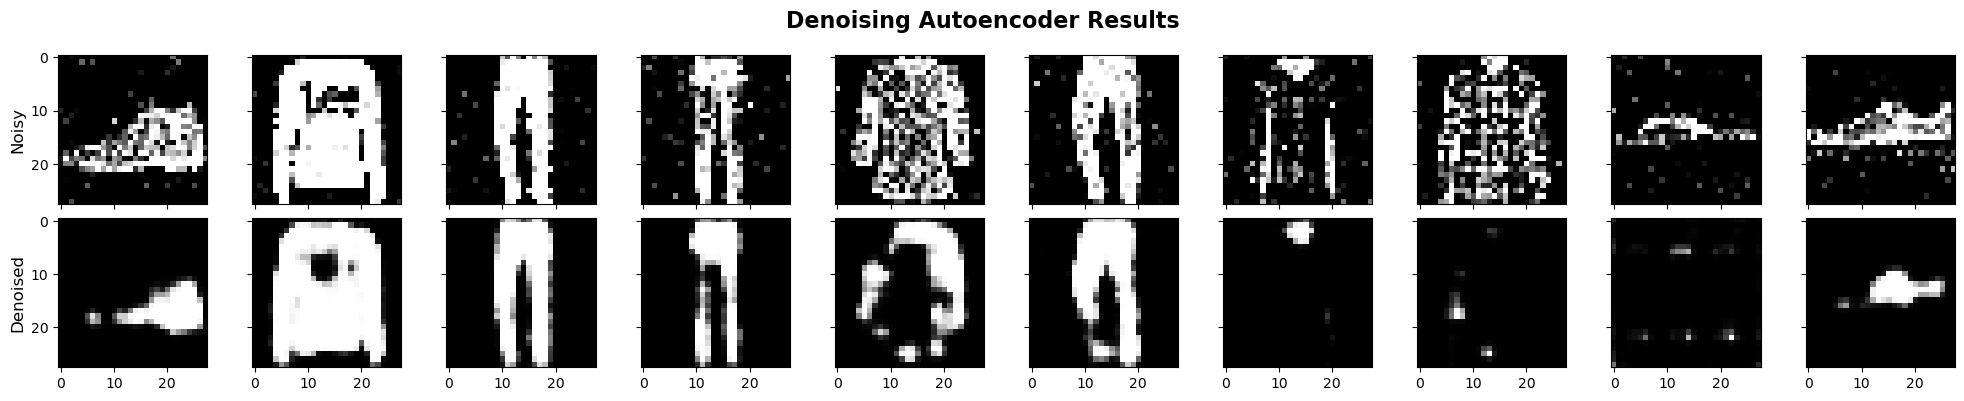

In [40]:
# Get one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Add noise
noisy_imgs = images + 0.5 * torch.randn_like(images)
noisy_imgs = torch.clamp(noisy_imgs, 0., 1.)

# Move to GPU
noisy_imgs_gpu = noisy_imgs.cuda()

# Get model output
model.eval()
with torch.no_grad():
    output = model(noisy_imgs_gpu)

# Reshape and move to CPU
output = output.view(-1, 1, 28, 28).cpu().numpy()

#pick 10 images to show
noisy_imgs = noisy_imgs[:10].numpy()
output = output[:10]

# Plot
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(20, 4), sharex=True, sharey=True)

for i in range(10):
    axes[0, i].imshow(noisy_imgs[i][0], cmap='gray')
    axes[1, i].imshow(output[i][0], cmap='gray')
    #axes[0, i].axis('off')
    #axes[1, i].axis('off')

axes[0, 0].set_ylabel('Noisy', fontsize=12)
axes[1, 0].set_ylabel('Denoised', fontsize=12)
plt.suptitle("Denoising Autoencoder Results", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()
